## Integrantes:
1. Camila Coltriani
2. Luis Dartayet
3. Irania Fuentes
4. Jonathan Fichelson
5. Ornella Cevoli

# Trabajo práctico 2 : Modelo de regresión lineal del dataset Properatti

## Objetivos

El objetivo de este trabajo final es generar y comparar estadísticamente tres modelos de regresión lineal sobre el dataset limpio de Properatti construido en el TP_1; en este, fue planteado la hipótesis que el precio (variable objetivo) de las propiedades iba a estar influenciado principalmente por la superficie y la ubicación (variables predictoras). 

Con base a esto, se han planteado los siguientes objetivos específicos:
- Explorar el dataset limpio con la finalidad de verificar si debe realizarse una ultima limpieza o pueden utilizase los datos directamente;
- Realizar una visualización general de las distribuciones y relaciones del dataset con la finalidad de determinar la zona, tipo de inmueble y variables predictoras y objetivo para la realización de los modelos;
- Construir modelos de regresión lineal simple y multiple e interpretar sus metricas con la finalidad de identificar el que mejor permita obtener una predicción confiable de la variable objetivo;
- Implementar un modelo de regularización con la finalidad de compararlos y evaluar si existe o no problemas de sobreajuste;
- Determinar el modelo que más se ajusta al comportamiento de los datos analizados. 

In [1]:
#Las librerías utilizadas en este documento son:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import metrics
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
sns.set()

## Visualización del dataset

In [2]:
# Visualización de la forma y atributos del dataset
data = pd.read_csv("./data/data_limpio_gdf.csv")
print(data.shape)
print("El dataset está compuesto por:", data.shape[0], "filas y",data.shape[1],"columnas.")
data.sample(5)

(45439, 15)
El dataset está compuesto por: 45439 filas y 15 columnas.


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,geometry,precio_usd_por_m2_cat
30745,San Lorenzo,Santa Fe,-32.773555,-60.738455,83.0,48792.79,house,3,587.864940,2,308,24,3,POINT (-60.7384554 -32.7735549),0
32791,La Plata,Bs.As. G.B.A. Zona Sur,-34.902819,-57.968386,33.0,58000.00,apartment,1,1757.575758,1,152,2,1,POINT (-57.9683858165 -34.9028194343),3
41520,Almagro,Capital Federal,-34.611058,-58.420189,77.0,190000.00,apartment,4 o mas,2467.532468,1,6,5,4,POINT (-58.4201892 -34.6110583),6
19364,Tres de Febrero,Bs.As. G.B.A. Zona Oeste,-34.590669,-58.568951,26.0,39146.40,apartment,1,1505.630769,1,348,1,1,POINT (-58.56895079999999 -34.590669299999995),2
19064,San Miguel,Bs.As. G.B.A. Zona Norte,-34.550284,-58.710765,80.0,125000.00,house,3,1562.500000,2,312,0,3,POINT (-58.7107646652 -34.550284243),3


### Descripción de las columnas del dataset limpio:

Las columnas que incluye son:

● municipio: ubicación del inmueble por su municipio/barrios

● provincia: ubicación del inmueble por provincia

● lat  ●lon: ubicación de latitud y longitud

● superficie_m2_total: superficie total en m² del inmueble

● price_usd: Precio en dólares del inmueble

● tipo: tipo de inmueble en venta (casa, departamento, ph, tienda)

● ambientes_cat: cantidad de ambientes del inmueble (0, 1, 2, 3 , 4 o más)

● precio_usd_por_m2: Precio en dólares por metro cuadrado (USD/m²: precio dólares / superficie)

● tipo_cat_code: categoría numérica de tipo de inmueble

● municipio_cat_code: categoría numérica de municipios

● provincia_cat_code: categoría numérica de provincia

● tipo_cat_code: categoría numérica de ambientes_cat

● geometry: figura geométrica de latitud y la longitud

● country_name: nombre del país donde ocurre la operación inmobiliaria

● **precio_usd_por_m2_cat: categoría numérica de precio_usd_por_m2**

# Análisis exploratorio y visualización de correlaciones entre las variables

In [3]:
#Revisamos la presencia de datos NaN
data.isna().sum().sort_values()
#La columna "ambientes_cat" quedó con 1248 registros nulos

municipio                   0
provincia                   0
lat                         0
lon                         0
sup_m2_total                0
precio_usd                  0
tipo                        0
precio_usd_por_m2           0
tipo_cat_code               0
municipio_cat_code          0
provincia_cat_code          0
ambientes_cat_code          0
geometry                    0
precio_usd_por_m2_cat       0
ambientes_cat            1248
dtype: int64

In [4]:
#reviso donde están ubicados y a que propiedad pertenecen los registros nulos para saber si afectaran escoger un tipo de inmueble y su zona
mascara_nulos = data["ambientes_cat"].astype(str) == "nan" 
data_nulos = data[mascara_nulos]
data_nulos.loc[:, ["municipio", 'tipo', 'ambientes_cat', "precio_usd"]].sample(7)
#print(data[mascara_nulos].index)

,municipio,tipo,ambientes_cat,precio_usd
27542,Morón,house,NaN,85000.0
19336,La Matanza,PH,NaN,72000.0
15299,Caballito,store,NaN,129900.0
36435,La Matanza,house,NaN,250000.0
17005,San Miguel,house,NaN,140000.0
34264,Morón,house,NaN,125000.0
28612,San Miguel,apartment,NaN,65500.0


In [5]:
#agrupamos los registros donde hay nulos
pd.options.display.max_rows = None
data_nulos.groupby(["tipo"])["municipio"].value_counts().sort_values(ascending=False)
#vemos que los nan están distribuidos equitativamente y no están concentrados en una mismo municipio

tipo       municipio                          
apartment  Córdoba                                73
           Rosario                                56
house      Almirante Brown                        55
apartment  Palermo                                33
house      Punilla                                29
           Córdoba                                28
store      Mar del Plata                          28
house      Lomas de Zamora                        26
           San Miguel                             26
           Ituzaingó                              22
           La Matanza                             21
           Morón                                  21
apartment  Villa Carlos Paz                       21
           Barrio Norte                           19
           Belgrano                               18
           Pinamar                                17
           San Miguel                             17
house      Bahía Blanca                           15

In [6]:
#Los elimino 
data.dropna(subset=['ambientes_cat'], inplace=True)
print(data.isna().sum())

municipio                0
provincia                0
lat                      0
lon                      0
sup_m2_total             0
precio_usd               0
tipo                     0
ambientes_cat            0
precio_usd_por_m2        0
tipo_cat_code            0
municipio_cat_code       0
provincia_cat_code       0
ambientes_cat_code       0
geometry                 0
precio_usd_por_m2_cat    0
dtype: int64


In [7]:
data.describe()
#existen datos que no permiten ver los estadísticos ya que hay valores de 0 en sup_m2_total e inf en precio_usd_por_m2: eliminarlos

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44191.000000,44191.000000,44191.000000,4.419100e+04,4.419100e+04,44191.000000,44191.000000,44191.000000,44191.000000,44191.000000
mean,-34.785068,-59.026417,105.113575,2.209563e+05,inf,1.239234,196.639225,5.586386,2.601480,4.525899
std,1.837082,2.031306,215.745400,3.174576e+05,NaN,0.608211,115.563981,5.823010,1.158737,2.849106
min,-54.806598,-71.665143,0.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659264,-58.576770,42.000000,8.600000e+04,1.450440e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455215,66.000000,1.350000e+05,2.047619e+03,1.000000,199.000000,5.000000,3.000000,5.000000
75%,-34.553173,-58.387126,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,inf,3.000000,399.000000,27.000000,4.000000,9.000000


In [8]:
#eliminamos del dataset los registros de sup_m2_total con valores de cero
data.drop(data[(data["sup_m2_total"] ==0)].index, inplace=True ,axis=0)

In [9]:
#Realizamos una descripción estadística del dataset
data.describe()
#Puede observarse mejor los estadisticos media, desv estandar y los minimos y maximos

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44163.000000,44163.000000,44163.000000,4.416300e+04,4.416300e+04,44163.000000,44163.000000,44163.000000,44163.000000,44163.000000
mean,-34.785448,-59.026233,105.180219,2.210394e+05,3.201985e+03,1.239363,196.590540,5.582818,2.602292,4.523062
std,1.837280,2.031694,215.797543,3.175383e+05,2.292673e+04,0.608365,115.574172,5.816332,1.158479,2.847780
min,-54.806598,-71.665143,1.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659311,-58.576394,42.000000,8.600000e+04,1.450000e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455138,66.000000,1.350000e+05,2.046512e+03,1.000000,198.000000,5.000000,3.000000,5.000000
75%,-34.553225,-58.387121,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,2.600000e+06,3.000000,399.000000,27.000000,4.000000,9.000000


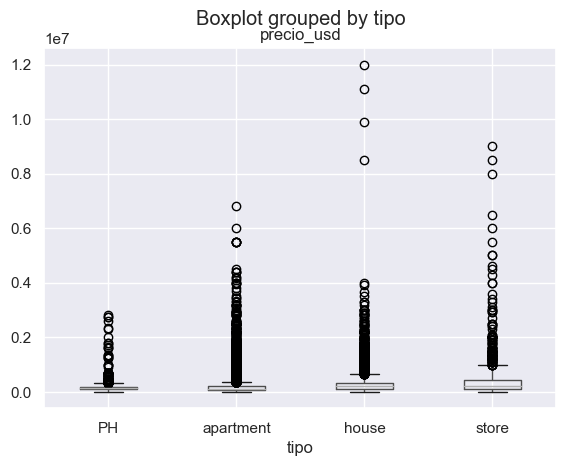

In [10]:
#mostramos un boxplot para los outliers por tipo de propiedad
data.boxplot(column= "precio_usd", by="tipo") 
plt.show()

In [11]:
# Eliminamos algunos outliers

data= data[(data["precio_usd"] >100) & (data["precio_usd"]<= 4.500000e+05)]
data= data[(data["precio_usd_por_m2"] > 100) & (data["precio_usd_por_m2"]<= 2.500000e+04)]

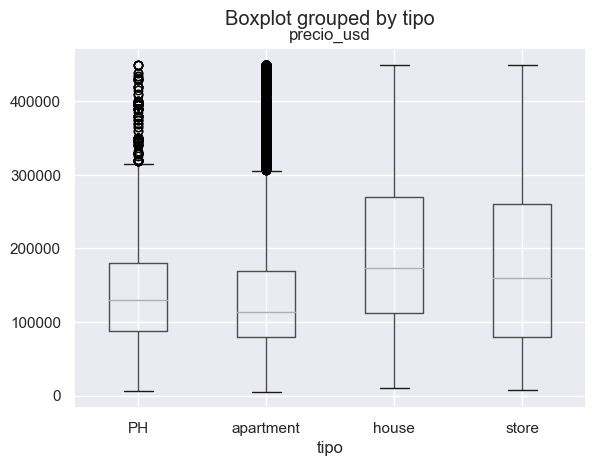

In [12]:
#mostramos un boxplot para los outliers por tipo de propiedad
data.boxplot(column= "precio_usd", by="tipo") 
plt.show()

#tenemos una mejor apreciacion de la distribucion de datos del dataset

In [13]:
#mostramos nuevamente como quedan los estadisticos del dataset filtado por outliers
data.describe()

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000,40016.000000
mean,-34.832163,-59.000561,87.596961,153833.003973,2218.548069,1.211241,195.991328,5.604683,2.521192,4.307602
std,1.861655,2.007858,80.657316,93936.604568,1547.864496,0.596365,115.699193,5.879857,1.136427,2.747178
min,-54.806598,-71.663515,1.000000,5103.610000,100.448358,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.675743,-58.575445,41.000000,84493.715000,1415.905236,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.607151,-58.455479,62.000000,125000.000000,1999.729730,1.000000,188.000000,5.000000,3.000000,4.000000
75%,-34.556172,-58.384543,105.000000,198000.000000,2673.647490,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,2500.000000,450000.000000,25000.000000,3.000000,399.000000,27.000000,4.000000,9.000000


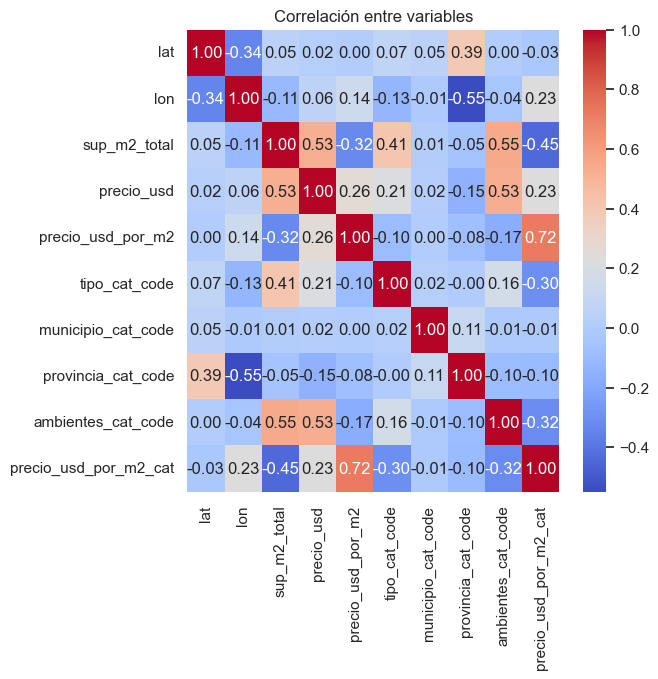

In [14]:
#Vemos la correlación entre las variables 
data_corr = data.corr()
#graficamos
plt.figure(figsize=(6,6))
sns.heatmap(data_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables")
plt.show()

#puede verse una correlación significativa entre sup_m2_total y precio_usd (0.39)
#tipo_cat_code / ambientes_cat_code y  precio_usd (0.30)
#precio_usd_por_m2_cat y lon

In [15]:
#graficamos las provincias y municipios que contengan un valor mínimo de 500 registros por municipio (para una mejor visualización)
limite = 500
data = data.copy().groupby(['municipio']).filter(lambda grp: grp.shape[0] > limite)

c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


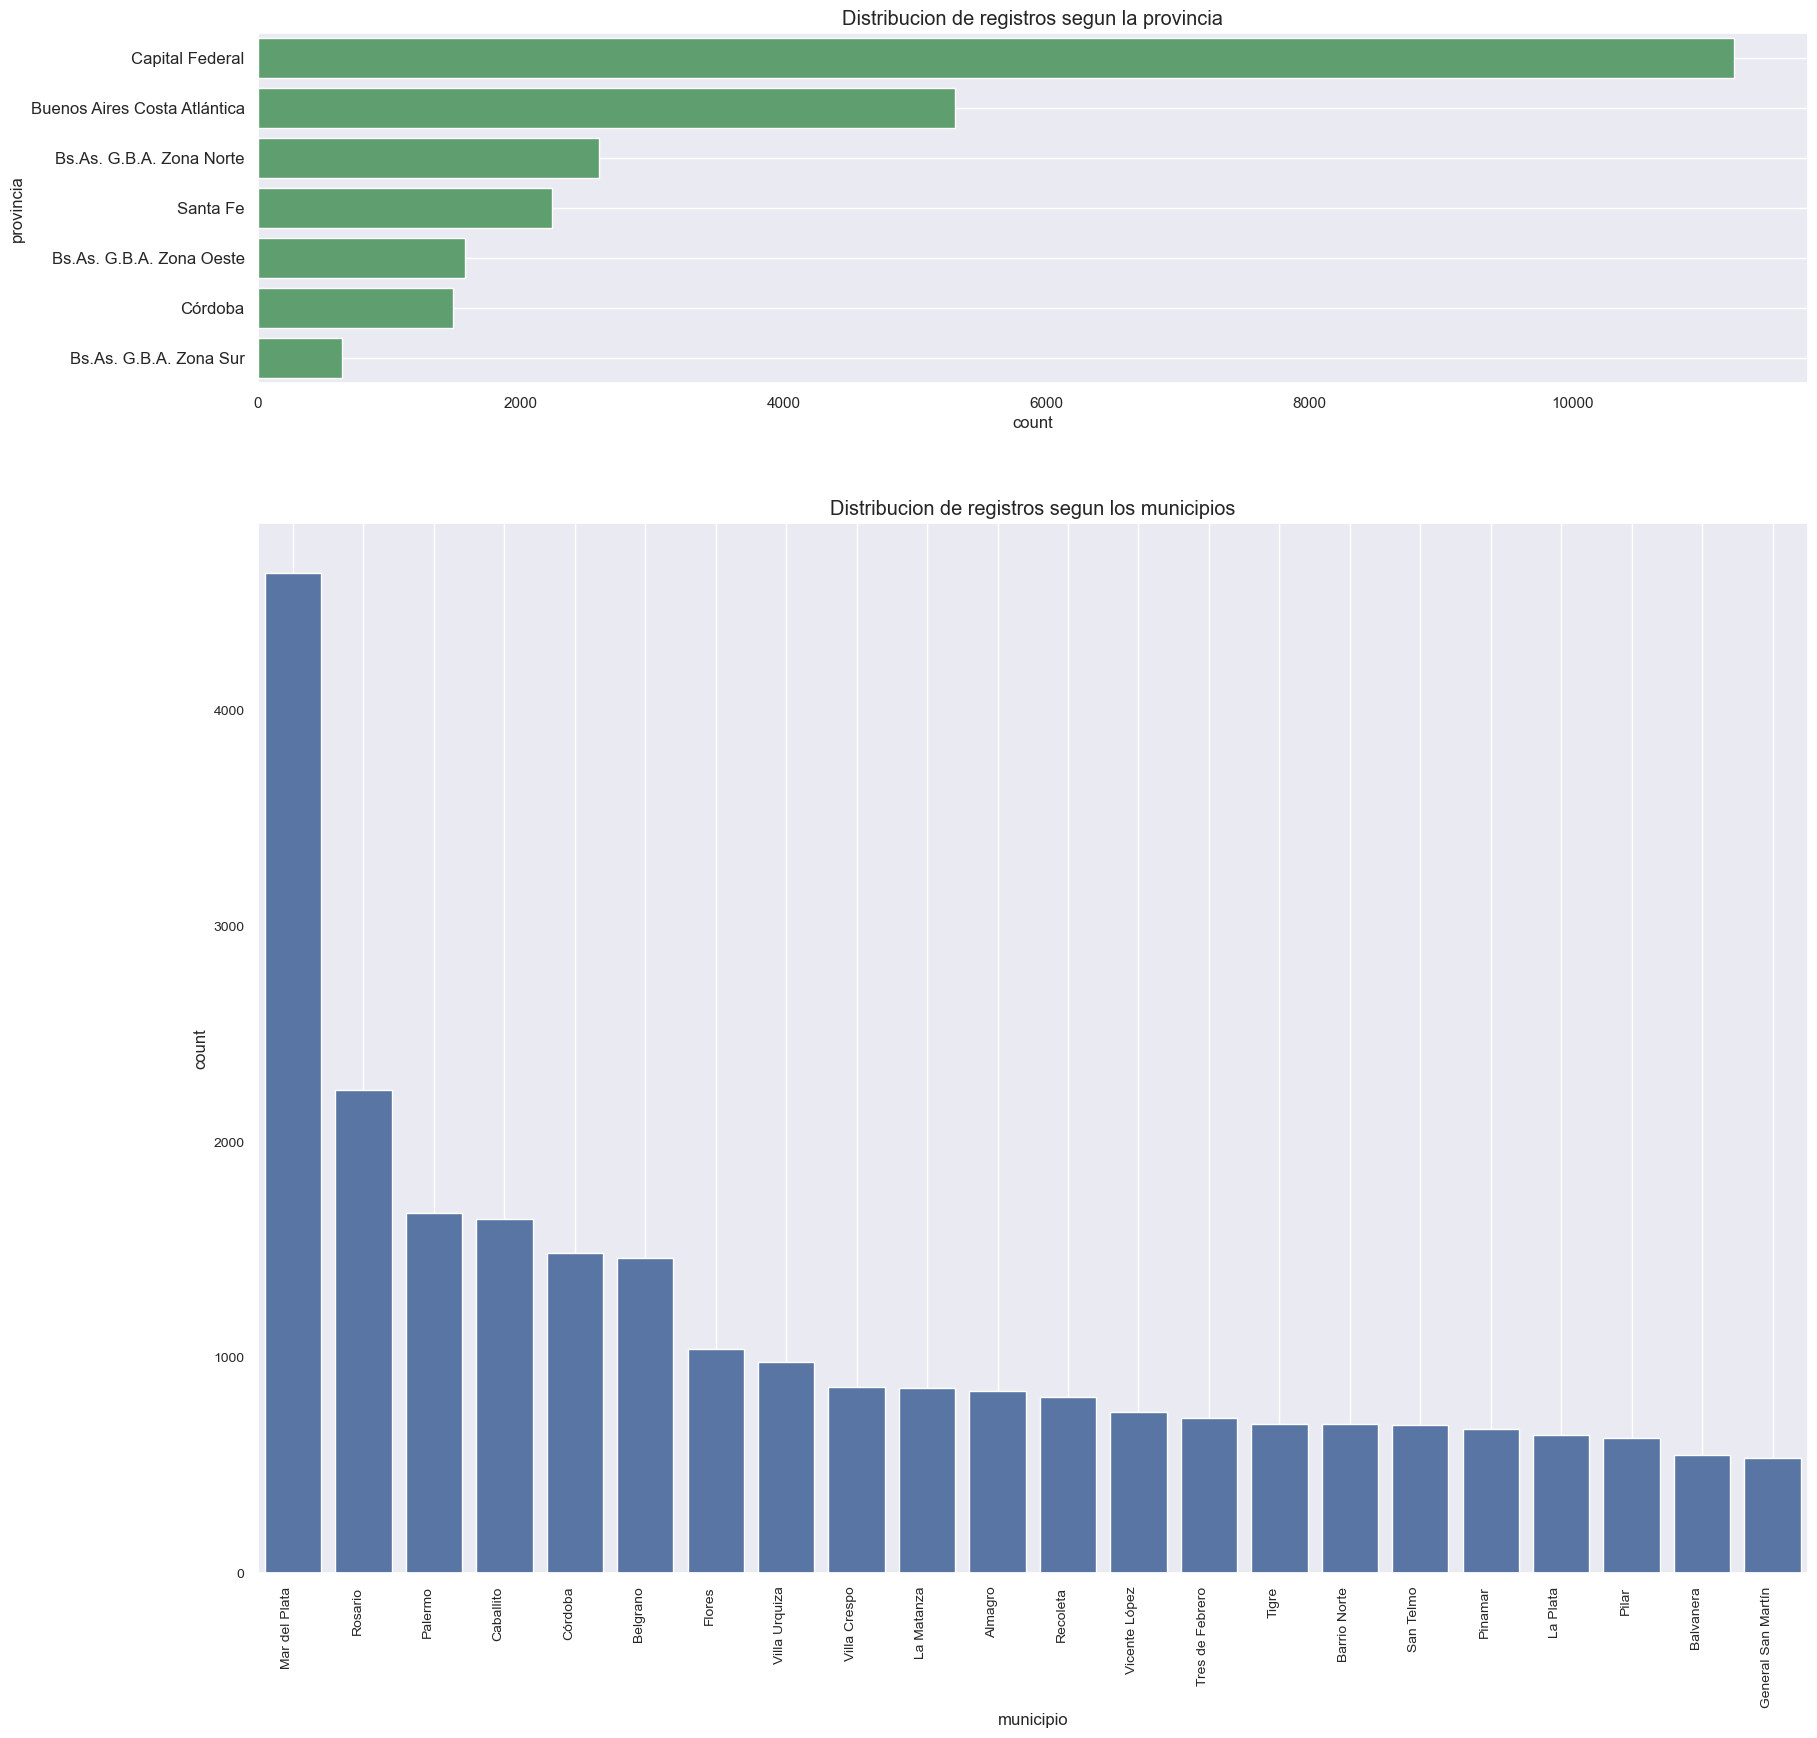

In [16]:
fig= plt.subplots(figsize=(20,20),constrained_layout=True)
grid = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

ax1=plt.subplot(grid[0])
sns.countplot(data=data,y="provincia",order=data["provincia"].value_counts().index ,ax=ax1,color="g")

ax1.set_yticklabels(ax1.get_yticklabels(),fontsize="medium")
ax1.set_title("Distribucion de registros segun la provincia", fontsize= 'large')

ax2=plt.subplot(grid[1])
sns.countplot(data=data,x="municipio",order=data["municipio"].value_counts().index,ax=ax2,color="b")


ax2.set_title("Distribucion de registros segun los municipios", fontsize= 'large')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90,ha="right")
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
ax1.grid()
ax2.grid()
plt.show()

La mayor cantidad de registros están Capital Federal para los barrios de Palermo, Belgrano, Caballito.
Consideraremos Capital Federal para la evaluación de los modelos 

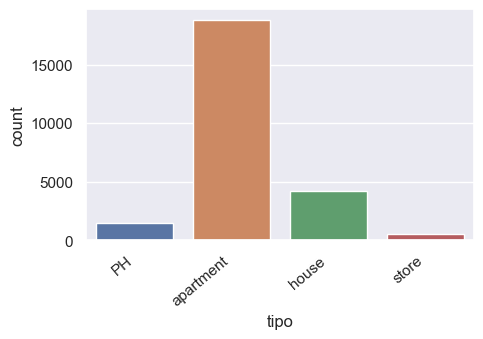

In [17]:
#Revisamos la distribución de registros por tipo de inmueble
plt.figure(figsize=(5,3))

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = data, x = "tipo")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.show()

#Apartamentos tiene la mayoría de los datos

Apartamentos puede ser una buena eleccion para la evaluacion de los modelos

In [18]:
#Revisamos la ubicacion de los los tipos de inmueble que contienen la mayor cantidad de registros
pd.options.display.max_rows = None
data.groupby(["municipio"])["tipo"].value_counts().sort_values(ascending=False)

municipio           tipo     
Mar del Plata       apartment    3308
Rosario             apartment    1875
Palermo             apartment    1523
Caballito           apartment    1518
Belgrano            apartment    1387
Mar del Plata       house         890
Flores              apartment     860
Villa Urquiza       apartment     844
Recoleta            apartment     774
Almagro             apartment     747
Córdoba             apartment     716
Villa Crespo        apartment     716
Córdoba             house         673
Barrio Norte        apartment     657
San Telmo           apartment     631
Tigre               house         506
Balvanera           apartment     490
Vicente López       apartment     450
Tres de Febrero     apartment     432
La Matanza          apartment     420
La Plata            apartment     403
Pinamar             apartment     380
Pilar               house         352
Mar del Plata       PH            342
Rosario             house         310
La Matanza          

## Correlación entre la variables del dataset

<Figure size 640x480 with 0 Axes>

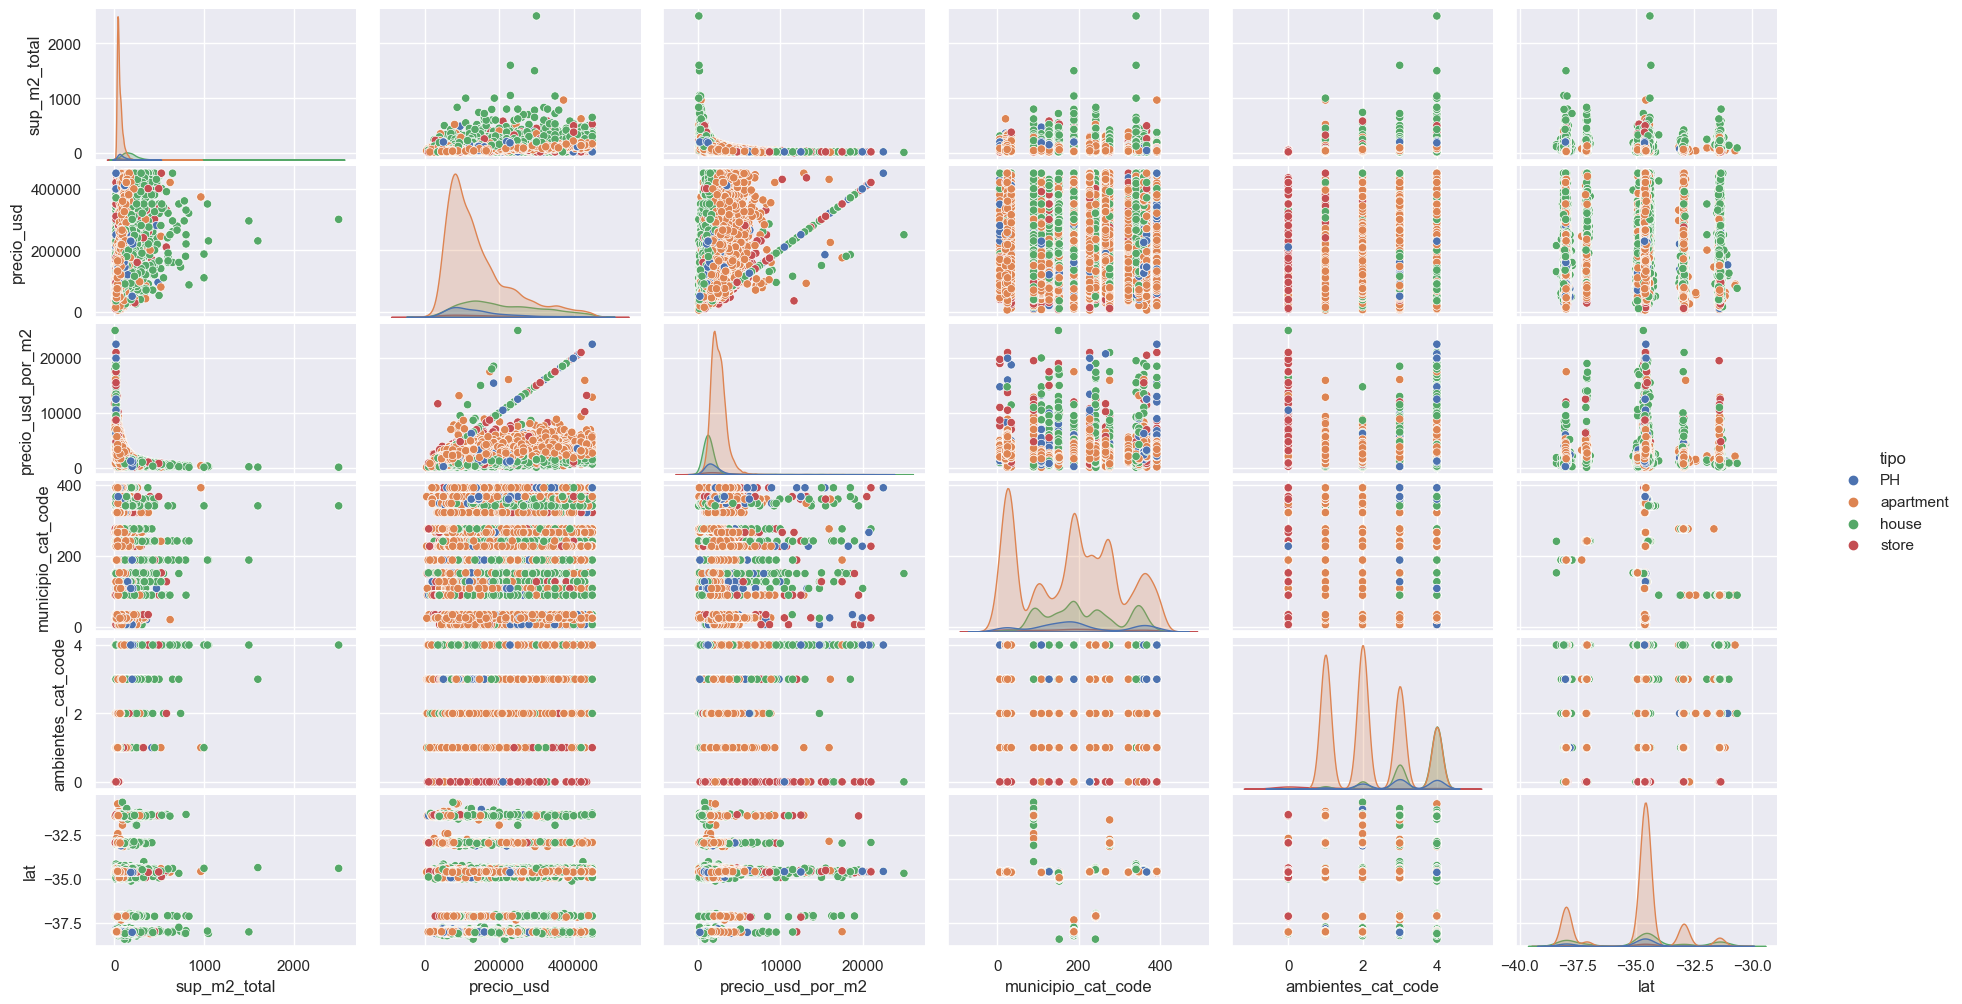

In [19]:
#analizamos la correlación entre cada una de las variables.
figz= plt.figure()
mask_cols= ["tipo","sup_m2_total","precio_usd","precio_usd_por_m2", "ambientes_cat", "municipio_cat_code", "ambientes_cat_code","lat"]
graph=sns.pairplot(data[mask_cols],hue="tipo")
graph.fig.set_size_inches(20,10)
plt.grid()
plt.show()


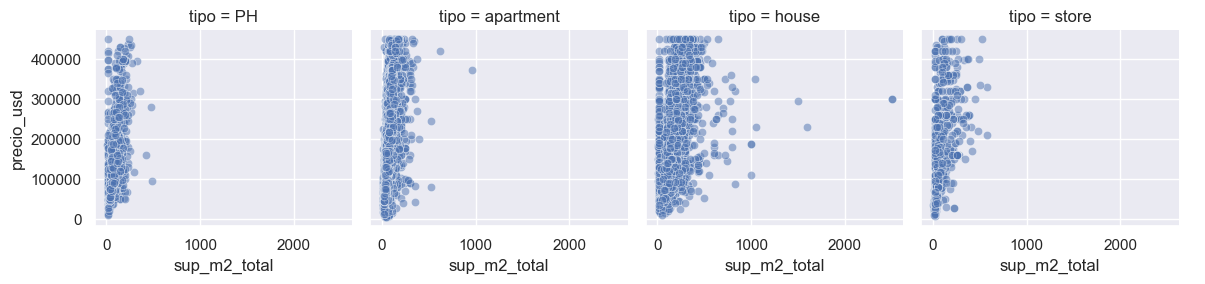

In [20]:
# Realizamos los siguientes gráficos para visualizar mejor (zoom) las relaciones- En primera medida analizamos metros totales con precio en dolares
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd", alpha=.5)
g.add_legend()


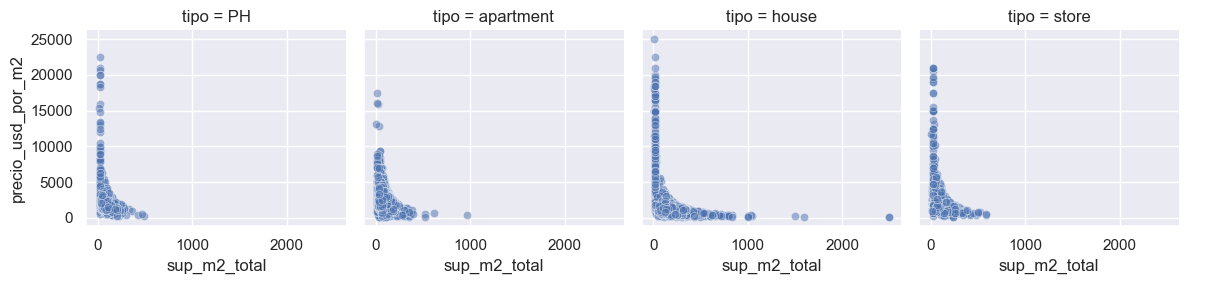

In [21]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd_por_m2", alpha=.5)
g.add_legend()

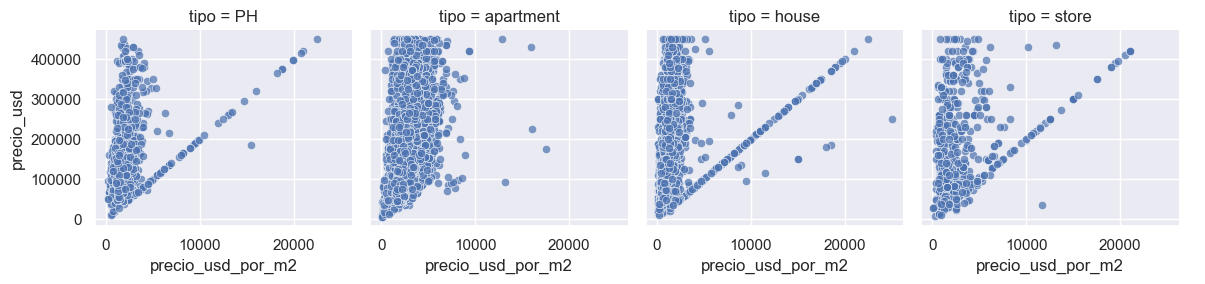

In [22]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "precio_usd_por_m2", "precio_usd", alpha=.7)
g.add_legend()

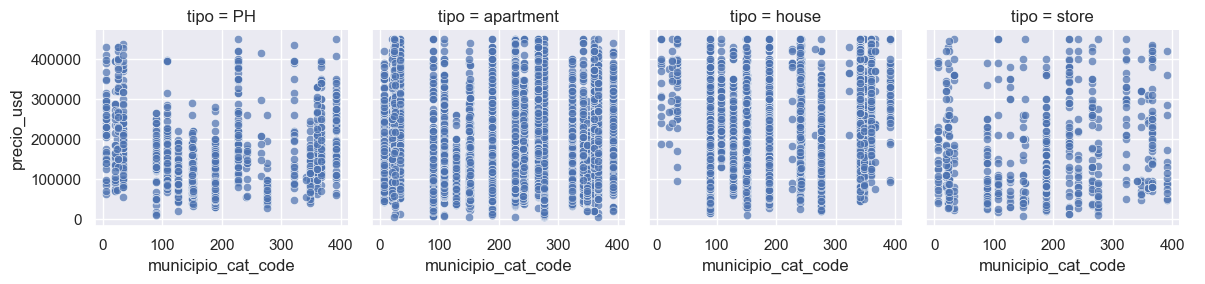

In [23]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "municipio_cat_code", "precio_usd", alpha=.7)
g.add_legend()

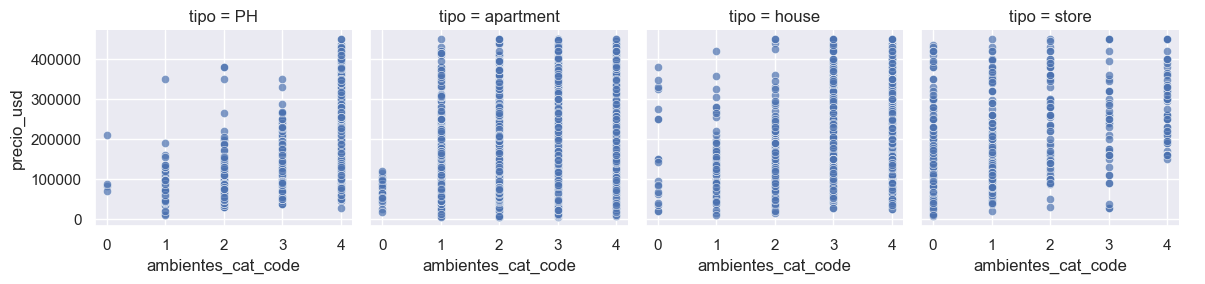

In [24]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "ambientes_cat_code", "precio_usd", alpha=.7)
g.add_legend()

#### la variable target debe tener una distribucion cercana a la normal

<AxesSubplot:xlabel='precio_usd', ylabel='Count'>

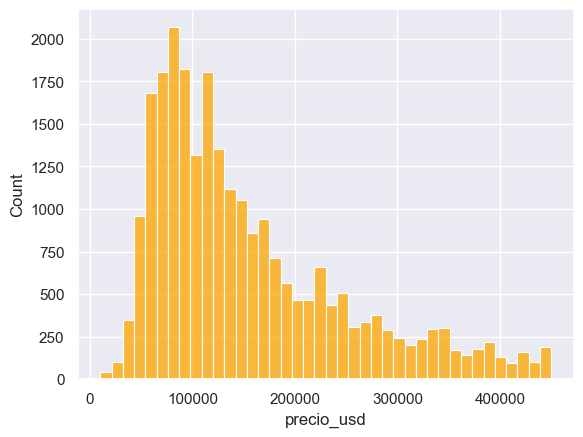

In [25]:
#de acuerdo con los valores mínimos y máximos realizamos un histograma para ver la distribución de datos de precio_usd
data_2= data[(data["precio_usd"] >10000) & (data["precio_usd"]<= 4.500000e+05)]
sns.histplot(data_2["precio_usd"], color = "orange", bins = 40)

<AxesSubplot:xlabel='sup_m2_total', ylabel='Count'>

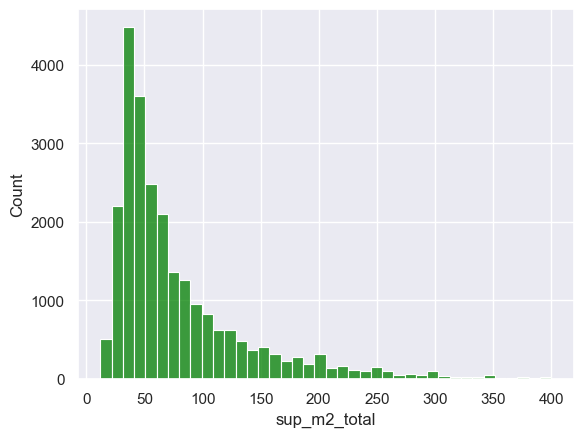

In [26]:
#de acuerdo con los valores mínimos y máximos realizamos un histograma para ver la distribución de datos de superficie total
data_2= data[(data["sup_m2_total"] >10) & (data["sup_m2_total"]<= 400)]
sns.histplot(data_2["sup_m2_total"], color = "green", bins = 40)

<AxesSubplot:xlabel='precio_usd_por_m2', ylabel='Count'>

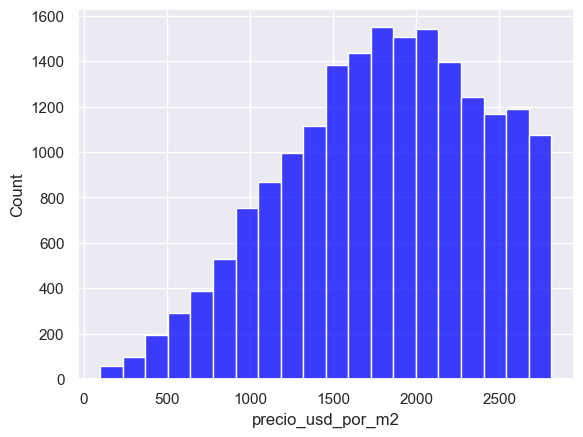

In [27]:
data_2= data[(data["precio_usd_por_m2"] >10) & (data["precio_usd_por_m2"]<= 2.812500e+03)]
sns.histplot(data_2["precio_usd_por_m2"], color = "blue", bins = 20)


#### Para determinar en que barrio enfocarnos, generaremos una función que correremos para los tres barrios enunciados  

Elegimos estos 3 barrios porque son los que tienen mayor cantidad de registros y mejor R2 inicial en el modelo de regresión lineal simple.
> confrontar con el archivo lr-barrios-capital.ipynb donde se corrió el modelo para todos los barrios de capital federal


In [28]:
# Seleccionamos las columnas que vamos a utilizar y sólo las propiedades de tipo apartamento

df_0 = data[data['tipo'] == 'apartment']
df_0 = data[['municipio', 'sup_m2_total', 'ambientes_cat', 'lat', 'lon', 'precio_usd' ]]
df_0.head()

,municipio,sup_m2_total,ambientes_cat,lat,lon,precio_usd
2,Vicente López,78.0,3,-34.532957,-58.521782,130000.0
3,Belgrano,40.0,1,-34.559873,-58.443362,138000.0
4,Belgrano,60.0,2,-34.559873,-58.443362,195000.0
10,Palermo,96.0,3,-34.580504,-58.405874,350000.0
11,Palermo,73.0,4 o mas,-34.590926,-58.411665,270500.0


In [29]:
# Extraemos un dataframe por cada columna

df_0_sup_m2_total = df_0[['sup_m2_total', 'precio_usd', 'municipio']]
df_0_ambientes_cat = df_0[['ambientes_cat', 'precio_usd', 'municipio']]
df_0_ubica = df_0[['lat', 'lon', 'precio_usd', 'municipio']]

In [30]:
# Armamos la función para las regresiones lineales

def regresion_lineal(df_0_lr, target, test_size=0.2, random_state=42):
    # Separamos la variable objetivo del resto del dataset
    X = df_0_lr.drop(target, axis=1)
    y = df_0_lr[target]
    
    # Dividimos el dataset en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Normalizamos los datos
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Instanciamos el modelo
    model = linear_model.LinearRegression()
    
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Predecimos con el modelo
    y_pred = model.predict(X_test)
    
    # Calculamos el R2
    r2 = r2_score(y_test, y_pred)
    
    # Imprimimos los resultados
    print('R2: ', r2)
    print('Intercept: ', model.intercept_)
    print('Coeficiente: ', model.coef_[0])
    
    # Graficamos los resultados
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred)
    plt.axline(xy1=(0, 0), slope=1, color='red')
    plt.xlabel('Valores reales')
    plt.ylabel('Valores predichos')
    plt.xlim(0, 1000000)
    plt.ylim(0, 1000000)
    plt.show()

In [31]:
#creamos una mascara para Palermo, Belgrano, Caballito.
municipios = np.array(['Palermo', 'Belgrano', 'Caballito'])

Municipio:  Palermo
R2:  0.6664725361118663
Intercept:  201738.11907726934
Coeficiente:  75341.2775871942


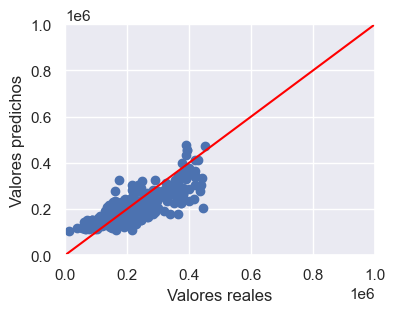

----------------------------------------
Municipio:  Belgrano
R2:  0.6586953542022871
Intercept:  202012.39146404108
Coeficiente:  79118.3073385938


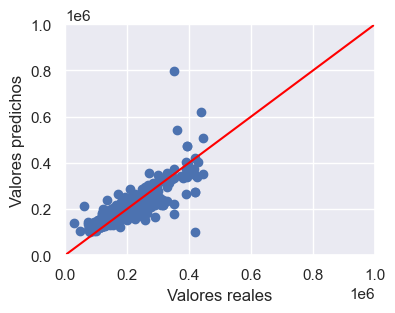

----------------------------------------
Municipio:  Caballito
R2:  0.6744525699830983
Intercept:  167686.53488939742
Coeficiente:  72467.72765221265


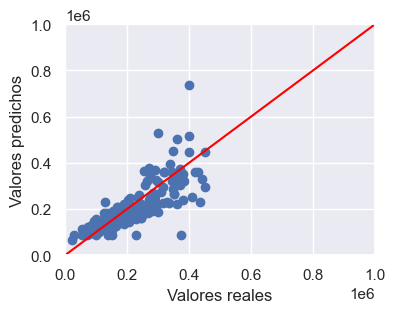

----------------------------------------


In [32]:
# Regresión lineal para el precio de las propiedades en función del municipio y la superficie total y guardamos el modelo en un mapa

for municipio in municipios:
    df_0_municipio =df_0_sup_m2_total[df_0_sup_m2_total['municipio'] == municipio]
    if(df_0_municipio.shape[0] > 100):
        df_0_municipio = df_0_municipio.drop('municipio', axis=1)
        print('Municipio: ', municipio)
        regresion_lineal(df_0_municipio, 'precio_usd')
        print('----------------------------------------')

Conclusiones del análisis de variables predictoras y target:
- La mayor cantidad de registros están Capital Federal para los barrios de Palermo, Belgrano, Caballito. Seleccionaremos el barrio Caballito porque que tiene una buena cantidad de registros y un buen R2 inicial en el modelo de regresión lineal simple inicial.
- Utilizaremos departamentos como el tipo de inmueble a modelar por contener una mayor cantidad de datos
- Consideraremos como variables predictora Superficie total y variable objetivo precio usd por su alta correlación, y su distribución. Luego evaluaremos el impacto de las variables de ubicación y ambientes.
